# Training and Fine-Tuning BERT for Classification
## Classfying Goodreads Reviews By Book Genre

By Maria Antoniak, Melanie Walsh, and the [AI for Humanists](https://aiforhumanists.com/) Team

Updated: 2024-11-05
<br></br>

This notebook will demonstrate how users can train and fine-tune a BERT model for classification with the popular HuggingFace `transformers` Python library.

We will fine-tune a BERT model on Goodreads reviews from the [UCSD Book Graph](https://mengtingwan.github.io/data/goodreads.html) with the goal of predicting the genre of the book being reviewed. The genres include:
- poetry
- comics & graphic
- fantasy & paranormal
- history & biography
- mystery, thriller, & crime
- romance
- young adult  

**Basic steps involved in using BERT and HuggingFace:**
1. Divide your data into training and test sets.
2. Encode your data into a format BERT will understand.
3. Combine your data and labels into datset objects.
4. Load the pre-trained BERT model.
5. Fine-tune the model using your training data.
6. Predict new labels and evaluate performance on your test data.



<br><br>

## **Import necessary Python libraries and modules**

In [1]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA version: {torch.version.cuda}")

CUDA available: True
GPU: NVIDIA GeForce GTX 1660 SUPER
CUDA version: 12.8


First, we will import necessary Python libraries and modules. These include as `gdown`, for downloading large files from Google Drive (where we will get our UCSD Goodreads reviews), as well as scikit-learn (`sklearn`) and PyTorch (`torch`), for various machine learning tools.

In [2]:
# Basic Python modules
from collections import defaultdict
import random
import pickle

# For working with JSON files
import json

# For data manipulation and analysis
import pandas as pd
import numpy as np

# For machine learning tools and evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# For deep learning
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
import torch

# For plotting and data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

The HuggingFace [`transformers` Python library](https://huggingface.co/transformers/installation.html) is included in Colab by default now, so we do not need to install it (but this is how you would install it with `pip`).

In [ ]:
#!pip3 install transformers

From `transformers`, we will import modules for `DistilBert`, a *distilled* or smaller version of a BERT model that runs more quickly and uses less computing power. This makes it ideal for those just getting started with BERT.

In [3]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

d:\project\massive_finetune\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<br><br>

## **Set parameters and file paths**

In [ ]:
# This is the name of the BERT model that we want to use.
# We're using DistilBERT to save space (it's a distilled version of the full BERT model),
# and we're going to use the cased (vs uncased) version.
model_name = 'distilbert-base-cased'

# This is the name of the program management system for NVIDIA GPUs. We're going to send our code here.
device_name = 'cuda'

# This is the maximum number of tokens in any document sent to BERT.
max_length = 512

LANGUAGE = "en-US"   # hoặc "vi-VN", "de-DE", ...

# This is the name of the directory where we'll save our model. You can name it whatever you want.
pt_model_path = './models/pt-model'
tflite_model_path = './models/tflite-model/model.tflite'
tf_model_path = "./models/tf-model"
# id2label = [
#     'romance', 'fantasy_paranormal', 'poetry', 'children',
#     'young_adult', 'mystery_thriller_crime', 'comics_graphic', 'history_biography'
# ]

# ==== Example ====
tests = [
    "A romantic story between two star-crossed lovers.",       # romance
    "A tale of vampires and magical adventures.",             # fantasy_paranormal
    "Roses are red, violets are blue, this poem is for you.",# poetry
    "Fun stories and illustrations for children.",           # children
    "A coming-of-age story about a young adult finding themselves.", # young_adult
    "Detectives chase a cunning criminal through the city.", # mystery_thriller_crime
    "A comic book adventure with superheroes and villains.", # comics_graphic
    "A detailed biography of Abraham Lincoln and his presidency.", # history_biography
    "Two lovers navigate a complicated relationship in Paris.",     # romance
    "A wizard battles dark forces in a haunted castle.",            # fantasy_paranormal
    "Ode to the stars shining bright in the night sky.",            # poetry
    "Colorful tales of talking animals and magical forests.",       # children
    "A young adult embarks on a journey of self-discovery.",        # young_adult
    "A thrilling chase as the detective hunts a serial thief.",     # mystery_thriller_crime
    "Superheroes team up to save the city from a giant robot.",    # comics_graphic
    "An in-depth account of Marie Curie's life and discoveries."    # history_biography
]

In [5]:
# Alias 
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizerFast

# Load tokenizer to use throughout the code
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)


<br><br>

## **Load and sample data**

In [7]:
from datasets import load_dataset

dataset = load_dataset("AmazonScience/massive", LANGUAGE)

train_texts, train_labels = [], []
test_texts, test_labels = [], []
valid_texts, valid_labels = [], []

# Train split
for item in dataset["train"]:
    train_texts.append(item["utt"])
    train_labels.append(item["intent"])

# Test split
for item in dataset["test"]:
    test_texts.append(item["utt"])
    test_labels.append(item["intent"])

# Validation split
for item in dataset["validation"]:
    valid_texts.append(item["utt"])
    valid_labels.append(item["intent"])

print("Dataset: AmazonScience/massive")
print("Number of training samples:", len(train_texts))
print("Number of test samples:", len(test_texts))
print("Number of validation samples:", len(valid_texts))

print("Samples from train:", train_texts[:3], train_labels[:3])
print("Samples from test:", test_texts[:3], test_labels[:3])
print("Samples from validation:", valid_texts[:3], valid_labels[:3])

Dataset: AmazonScience/massive
Number of training samples: 11514
Number of test samples: 2974
Number of validation samples: 2033
Samples from train: ['wake me up at nine am on friday', 'set an alarm for two hours from now', 'olly quiet'] [48, 48, 46]
Samples from test: ['wake me up at five am this week', 'quiet', 'pink is all we need'] [48, 46, 1]
Samples from validation: ['turn the lights off please', 'dim the lights in the hall', 'make a room darker'] [40, 31, 31]


In [64]:
# Tạo dict chỉ chứa utt + intent
massive_data = {
    "train": [(item["utt"], item["intent"]) for item in dataset["train"]],
    "test": [(item["utt"], item["intent"]) for item in dataset["test"]],
    "validation": [(item["utt"], item["intent"]) for item in dataset["validation"]],
}

# Lưu ra pickle
with open("massive_dataset.pickle", "wb") as f:
    pickle.dump(massive_data, f)

# with open("massive_dataset.pickle", "rb") as f:
#     massive_data = pickle.load(f)

# train_texts, train_labels = zip(*massive_data["train"])
# test_texts, test_labels = zip(*massive_data["test"])
# valid_texts, valid_labels = zip(*massive_data["validation"])




<br><br>

## **Run a baseline model (logistic regression)**

Here we train and evaluate a simple TF-IDF baseline model using logistic regression.

We find better-than-random performance, even for a very small dataset. We'll see whether BERT can beat this good baseline!

In [8]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

We train a logistic regression model from scikit-learn on the Goodreads training data, and then we use the trained model to make predictions on our Goodreads review test set.

In [9]:
model = LogisticRegression(max_iter=1000).fit(X_train, train_labels)
predictions = model.predict(X_test)

We can use scikit-learn's `classification_report` function to evaluate how well the logistic regression model's predictions match up with the true labels for the Goodreads reviews.

Importantly, we can see that our average scores are above random performance (we have 8 classes, so random performance would be ~0.2).

In [10]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88        88
           1       0.91      0.89      0.90        36
           2       0.97      0.83      0.89        35
           3       0.92      0.63      0.75        35
           4       0.92      0.88      0.90        26
           5       0.00      0.00      0.00         1
           6       0.79      0.70      0.74        43
           7       0.00      0.00      0.00         4
           8       0.92      0.67      0.77        18
           9       0.98      0.78      0.87        72
          10       0.95      0.92      0.94        39
          11       0.83      1.00      0.91        15
          12       0.45      0.66      0.53       169
          13       0.86      0.93      0.90       156
          14       0.56      0.69      0.62        13
          15       0.67      0.50      0.57        12
          16       0.77      0.77      0.77        22
          17       0.71    

d:\project\massive_finetune\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\project\massive_finetune\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\project\massive_finetune\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<br><br>

## **Encode data for BERT**

We're going to transform our texts and labels into a format that BERT (via Huggingface and PyTorch) will understand. This is called *encoding* the data.

Here are the steps we need to follow:

1. The labels&mdash;in this case, Goodreads genres&mdash;need to be turned into integers rather than strings.

2. The texts&mdash;in this case, Goodreads reviews&mdash;need to be truncated if they're more than 512 tokens or padded if they're fewer than 512 tokens. The tokens, or words in the texts, also need to be separated into "word pieces" and matched to their embedding vectors.

3. We need to add special tokens to help BERT:

| BERT special token | Explanation |
| --------------| ---------|
| [CLS] | Start token of every document. |
| [SEP] | Separator between each sentence |
| [PAD] | Padding at the end of the document as many times as necessary, up to 512 tokens |
|  &#35;&#35; | Start of a "word piece" |




Here we will load `DistilBertTokenizerFast` from the HuggingFace library, which will do all the work of encoding the texts for us. The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [11]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name) # The model_name needs to match our pre-trained model.

Here we will create a map of our labels, or Goodreads genres, to integer keys. We take the unique labels, and then we make a dictionary that associates each label/tag with an integer.

**Note:** HuggingFace documentation sometimes refers to "labels" as "tags" but these are the same thing. We use "labels" throughout this notebook for clarity.

In [20]:
import json

with open("./models/intent_mapping.json", "r", encoding="utf-8") as f:
    id2label = json.load(f)

id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

print("id2label:", id2label)
print("label2id:", label2id)

id2label: {0: 'datetime_query', 1: 'iot_hue_lightchange', 2: 'transport_ticket', 3: 'takeaway_query', 4: 'qa_stock', 5: 'general_greet', 6: 'recommendation_events', 7: 'music_dislikeness', 8: 'iot_wemo_off', 9: 'cooking_recipe', 10: 'qa_currency', 11: 'transport_traffic', 12: 'general_quirky', 13: 'weather_query', 14: 'audio_volume_up', 15: 'email_addcontact', 16: 'takeaway_order', 17: 'email_querycontact', 18: 'iot_hue_lightup', 19: 'recommendation_locations', 20: 'play_audiobook', 21: 'lists_createoradd', 22: 'news_query', 23: 'alarm_query', 24: 'iot_wemo_on', 25: 'general_joke', 26: 'qa_definition', 27: 'social_query', 28: 'music_settings', 29: 'audio_volume_other', 30: 'calendar_remove', 31: 'iot_hue_lightdim', 32: 'calendar_query', 33: 'email_sendemail', 34: 'iot_cleaning', 35: 'audio_volume_down', 36: 'play_radio', 37: 'cooking_query', 38: 'datetime_convert', 39: 'qa_maths', 40: 'iot_hue_lightoff', 41: 'iot_hue_lighton', 42: 'transport_query', 43: 'music_likeness', 44: 'email_que

In [21]:
label2id.keys()

dict_keys(['datetime_query', 'iot_hue_lightchange', 'transport_ticket', 'takeaway_query', 'qa_stock', 'general_greet', 'recommendation_events', 'music_dislikeness', 'iot_wemo_off', 'cooking_recipe', 'qa_currency', 'transport_traffic', 'general_quirky', 'weather_query', 'audio_volume_up', 'email_addcontact', 'takeaway_order', 'email_querycontact', 'iot_hue_lightup', 'recommendation_locations', 'play_audiobook', 'lists_createoradd', 'news_query', 'alarm_query', 'iot_wemo_on', 'general_joke', 'qa_definition', 'social_query', 'music_settings', 'audio_volume_other', 'calendar_remove', 'iot_hue_lightdim', 'calendar_query', 'email_sendemail', 'iot_cleaning', 'audio_volume_down', 'play_radio', 'cooking_query', 'datetime_convert', 'qa_maths', 'iot_hue_lightoff', 'iot_hue_lighton', 'transport_query', 'music_likeness', 'email_query', 'play_music', 'audio_volume_mute', 'social_post', 'alarm_set', 'qa_factoid', 'calendar_set', 'play_game', 'alarm_remove', 'lists_remove', 'transport_taxi', 'recommen

In [22]:
id2label.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

Now let's encode our texts and labels!

In [30]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

# massive data: label already convert to num
# train_labels_encoded = [label2id[y] for y in train_labels]
# test_labels_encoded  = [label2id[y] for y in test_labels]
train_labels_encoded = train_labels
test_labels_encoded = test_labels

**Examine a Goodreads review in the training set after encoding**

In [27]:
' '.join(train_encodings[0].tokens[0:500])

'[CLS] wake me up at nine am on f ##rida ##y [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

**Examine a Goodreads review in the test set after encoding**

In [31]:
' '.join(test_encodings[0].tokens[0:100])

'[CLS] wake me up at five am this week [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

**Examine the training labels after encoding**

In [32]:
set(train_labels_encoded)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59}

**Examine the test labels after encoding**

In [33]:
set(test_labels_encoded)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59}

<br><br>

## **Make a custom Torch dataset**

Here we combine the encoded labels and texts into dataset objects. We use the custom Torch `MyDataSet` class to make a `train_dataset` object from  the `train_encodings` and `train_labels_encoded`. We also make a `test_dataset` object from `test_encodings`, and `test_labels_encoded`.

In [34]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [35]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

**Examine a Goodreads review in the Torch `training_dataset` after encoding**

In [36]:
' '.join(train_dataset.encodings[0].tokens[0:100])

'[CLS] wake me up at nine am on f ##rida ##y [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

**Examine a Goodreads review in the Torch `test_dataset` after encoding**

In [38]:
' '.join(test_dataset.encodings[1].tokens[0:100])

'[CLS] quiet [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

<br><br>

## **Load pre-trained BERT model**

Here we load a pre-trained DistilBERT model and send it to CUDA.

**Note:** If you decide to repeat fine-tuning after already running the following cells, make sure that you re-run this cell to re-load the original pre-trained model before fine-tuning again.

In [39]:
# The model_name needs to match the name used for the tokenizer above.
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<br><br>

## **Set the BERT fine-tuning parameters**

These are the arguments we'll set in the HuggingFace TrainingArguments objects, which we'll then pass to the HuggingFace Trainer object. There are many more possible arguments, but here we highlight the basics and some common gotchas.

When training your own model, you should search over these parameters to find the best settings for your particular dataset. You should use a held-out set of validation data for this step.

In [40]:
import transformers
print(transformers.__version__)


4.53.3


| Parameter | Explanation |
|-----------| ------------|
| num_train_epochs | total number of training epochs (how many times to pass through the entire dataset; too much can cause overfitting) |
| per_device_train_batch_size | batch size per device during training |
| per_device_eval_batch_size |  batch size for evaluation |
|  warmup_steps |  number of warmup steps for learning rate scheduler (set lower because of small dataset size) |
| weight_decay | strength of weight decay (reduces size of weights, like regularization) |
| output_dir | output directory for the fine-tuned model and configuration files |
| logging_dir | directory for storing logs |
| logging_steps | how often to print logging output (so that we can stop training early if the loss isn't going down) |
| evaluation_strategy | evaluate while training so that we can see the accuracy going up |

In [41]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./models/results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    eval_strategy='steps',     # evaluate during fine-tuning so that we can see progress
    report_to=[],  # Disables wandb logging
)

<br><br>

## **Fine-tune the BERT model**

First, we define a custom evaluation function that returns the accuracy. You could modify this function to return precision, recall, F1, and/or other metrics.

In [42]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

Then we create a HuggingFace `Trainer` object using the `TrainingArguments` object that we created above. We also send our `compute_metrics` function to the `Trainer` object, along with our test and train datasets.

**Note:** This is what we've been aiming for this whole time! All the work of tokenizing, creating datasets, and setting the training arguments was for this cell.

In [43]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics      # our custom evaluation function
)

Time to finally fine-tune!

Be patient; if you've set everything in Colab to use GPUs, then it should only take a minute or two to run, but if you're running on CPU, it can take hours.

After every 10 steps (as we specified in the TrainingArguments object), the trainer will output the current state of the model, including the training loss, validation ("test") loss, and accuracy (from our `compute_metrics` function).

You should see the loss going down and the accuracy going up. If instead they are staying the same or oscillating, you probably need to change the fine-tuning parameters.

In [44]:
# Turn off weights and biases logging, which requires an API key

import os
os.environ["WANDB_DISABLED"] = "true"

In [45]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,3.806700,2.959271,0.387357
200,2.281400,1.646556,0.651648
300,1.456600,1.141945,0.744116
400,1.048100,0.901862,0.784129
500,0.947700,0.768087,0.814391
600,0.798500,0.677624,0.833557
700,0.734700,0.631893,0.839610
800,0.497500,0.630629,0.832213
900,0.426400,0.574455,0.850706
1000,0.420300,0.550557,0.857431


TrainOutput(global_step=2160, training_loss=0.7173837383588155, metrics={'train_runtime': 331.199, 'train_samples_per_second': 104.294, 'train_steps_per_second': 6.522, 'total_flos': 384683856858000.0, 'train_loss': 0.7173837383588155, 'epoch': 3.0})

<br><br>

## **Save fine-tuned model**

The following cell will save the model and its configuration files to a directory in Colab. To preserve this model for future use, you should download the model to your computer.

In [46]:
trainer.save_model(pt_model_path)

(Optional) If you've already fine-tuned and saved the model, you can reload it using the following line. You don't have to run fine-tuning every time you want to evaluate.

In [ ]:
# trainer = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name)

<br><br>

## **Evaluate fine-tuned model**

The following function of the `Trainer` object will run the built-in evaluation, including our `compute_metrics` function.

In [47]:
trainer.evaluate()

{'eval_loss': 0.4943583607673645,
 'eval_accuracy': 0.8782784129119031,
 'eval_runtime': 6.9661,
 'eval_samples_per_second': 426.927,
 'eval_steps_per_second': 21.389,
 'epoch': 3.0}

But we might want to do more fine-grained analysis of the model, so we extract the predicted labels.

In [48]:
predicted_results = trainer.predict(test_dataset)

In [49]:
predicted_results.predictions.shape

(2974, 60)

In [50]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [51]:
len(predicted_labels)

2974

In [56]:
test_labels = [id2label[y] for y in test_labels_encoded]
print(classification_report(test_labels,
                            predicted_labels))

                          precision    recall  f1-score   support

             alarm_query       0.97      0.97      0.97        34
            alarm_remove       0.95      0.95      0.95        21
               alarm_set       0.93      0.95      0.94        41
       audio_volume_down       0.83      0.91      0.87        11
       audio_volume_mute       0.86      0.94      0.90        32
      audio_volume_other       1.00      0.17      0.29         6
         audio_volume_up       0.71      0.92      0.80        13
          calendar_query       0.82      0.85      0.83       126
         calendar_remove       0.90      0.97      0.94        67
            calendar_set       0.92      0.92      0.92       209
          cooking_recipe       0.92      0.92      0.92        72
        datetime_convert       0.69      0.73      0.71        15
          datetime_query       0.93      0.92      0.93        88
        email_addcontact       0.62      0.83      0.71        12
         

<br><br>

## **Pull out correct and incorrect classifications for examination**

Let's use our predicted labels for some analysis!

Now that we've fine-tuned and pulled out our predicted labels, the BERT part of this tutorial is done. You can now use the predicted labels in the same way you would use any set of predicted labels from any classification model. We'll show some examples here.

First, let's print out some example predictions that were correct.

In [57]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label == _predicted_label:
    print('LABEL:', _true_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

LABEL: social_post
REVIEW TEXT: post a new status on facebook saying that i am enjoying the nice weather ...

LABEL: play_music
REVIEW TEXT: olly i need to hear some sad songs today ...

LABEL: general_joke
REVIEW TEXT: what's a good joke ...

LABEL: music_query
REVIEW TEXT: title of song ...

LABEL: alarm_set
REVIEW TEXT: please set my alarm for five p. m. ...

LABEL: takeaway_order
REVIEW TEXT: call for take-out ...

LABEL: email_sendemail
REVIEW TEXT: help is to be sent only to jane ...

LABEL: qa_factoid
REVIEW TEXT: which is the highest peak in the world ...

LABEL: takeaway_query
REVIEW TEXT: hows the food order going ...

LABEL: qa_factoid
REVIEW TEXT: what year did george clooney start acting ...

LABEL: cooking_recipe
REVIEW TEXT: what is the best oven temperature to roast potatoes ...

LABEL: news_query
REVIEW TEXT: i want to hear the last news from c. n. n. ...

LABEL: iot_cleaning
REVIEW TEXT: please start vacuum cleaner ...

LABEL: iot_coffee
REVIEW TEXT: start coffee at s

Now let's print out some misclassifications.

In [58]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label != _predicted_label:
    print('TRUE LABEL:', _true_label)
    print('PREDICTED LABEL:', _predicted_label)
    print('REVIEW TEXT:', _text[:100], '...')
    print()

TRUE LABEL: email_addcontact
PREDICTED LABEL: email_sendemail
REVIEW TEXT: locate the email to giant eagle and put it into my contact list ...

TRUE LABEL: lists_remove
PREDICTED LABEL: calendar_remove
REVIEW TEXT: remove my car payment on my calendar ...

TRUE LABEL: general_quirky
PREDICTED LABEL: news_query
REVIEW TEXT: baseball scores ...



Finally, let's create some heatmaps to examine misclassification patterns. We could use these patterns to think about similarities and differences between genres, according to book reviewers.

In [59]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  genre_classifications_dict[(_true_label, _predicted_label)] += 1

dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})

df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre',
                                 columns='Predicted Genre',
                                 values='Number of Classifications')

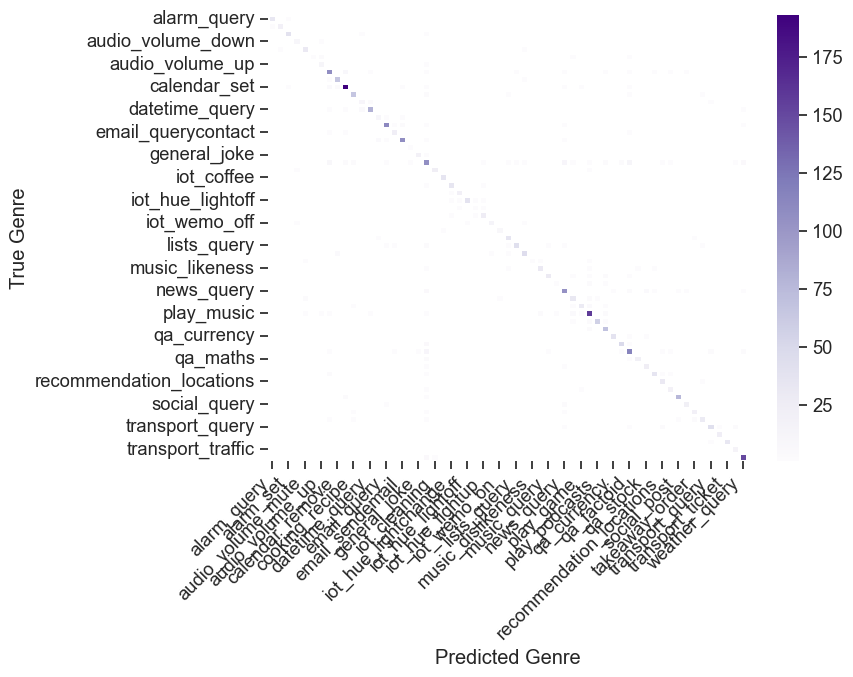

In [60]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Looks good! We can see that overall, our model is assigning the correct labels for each genre.

Now, let's remove the diagonal from the plot to highlight the misclassifications.

In [61]:
genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  if _true_label != _predicted_label: # Remove the diagonal to highlight misclassifications
    genre_classifications_dict[(_true_label, _predicted_label)] += 1

dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
  dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})

df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre',
                                 columns='Predicted Genre',
                                 values='Number of Classifications')

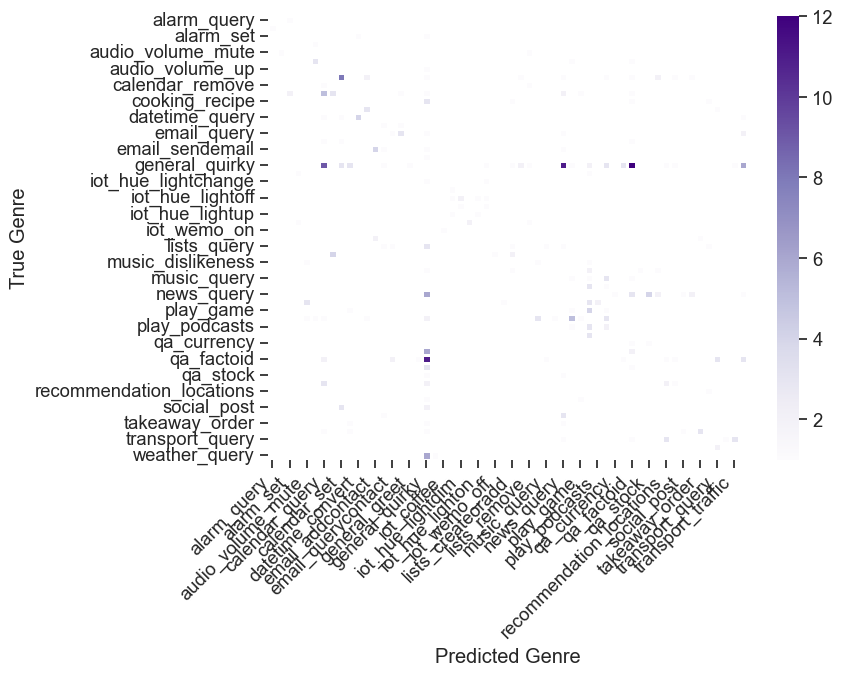

In [62]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There's much more you can do with your own dataset and labels! Classification can be used to apply a small set of labels across a big dataset; to explore misclassifications to better understand users; and much more! We hope you'll use this tutorial in all kinds of creative ways.

## Evaluate random samples ***

In [78]:
import random

def evaluate_random_samples(predict_fn, n=10):
    """
    predict_fn: hàm nhận list[str] -> list[str] (trả về nhãn dự đoán)
    n: số sample muốn test
    """
    pairs = list(zip(valid_labels, valid_texts))
    random.shuffle(pairs)

    for label, text in pairs[:n]:
        predicted = predict_fn([text])[0]
        expected = id2label[label]

        print(f"Text: {text}")
        print(f"Predicted: {predicted}")
        print(f"Expected : {expected}")
        print("✅" if predicted == expected else "❌")
        print("-" * 10)


# PT to TFLite using Optimum-cli

## Optimum converter

In [ ]:
!pip install optimum[exporters] --upgrade
!optimum-cli --help
# python3 alias need to setup


In [ ]:
!optimum-cli export tflite --model ./distilbert-reviews-genres --task text-classification --sequence_length 512 "models/tflite-model-optimum"

## Inference TFLite Op

In [ ]:

# ==== Load TFLite model ====
interpreter = tf.lite.Interpreter(model_path="models/tflite-model-optimum")


interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
for detail in input_details:
    print(f"Expected dtype: {detail['dtype']}")

output_details = interpreter.get_output_details()
def predict_tflite_op(texts):
    # texts: list of strings
    inputs = tokenizer(
        texts,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="np"
    )

    # TFLite model yêu cầu int64
    input_ids = inputs["input_ids"].astype(np.int64)         # shape (batch, seq_len)
    attention_mask = inputs["attention_mask"].astype(np.int64)

    # Set inputs
    for detail in input_details:
        if "input_ids" in detail["name"]:
            interpreter.set_tensor(detail["index"], input_ids)
        elif "attention_mask" in detail["name"]:
            interpreter.set_tensor(detail["index"], attention_mask)
        else:
            interpreter.set_tensor(detail["index"], np.zeros(input_ids.shape, dtype=np.int64))

    # Run inference
    interpreter.invoke()

    # Get output
    output_data = interpreter.get_tensor(output_details[0]["index"])
    preds = np.argmax(output_data, axis=1)

    return [id2label[i] for i in preds]

# Example
for text in tests:
    label = predict_tflite_op(text)
    print(f"Text: {text}\nPredicted label: {label}\n")


d:\project\massive_finetune\venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Expected dtype: <class 'numpy.int64'>
Expected dtype: <class 'numpy.int64'>
Text: A romantic story between two star-crossed lovers.
Predicted label: ['fantasy_paranormal']

Text: A tale of vampires and magical adventures.
Predicted label: ['comics_graphic']

Text: Roses are red, violets are blue, this poem is for you.
Predicted label: ['children']

Text: Fun stories and illustrations for children.
Predicted label: ['history_biography']

Text: A coming-of-age story about a young adult finding themselves.
Predicted label: ['history_biography']

Text: Detectives chase a cunning criminal through the city.
Predicted label: ['romance']

Text: A comic book adventure with superheroes and villains.
Predicted label: ['poetry']

Text: A detailed biography of Abraham Lincoln and his presidency.
Predicted label: ['mystery_thriller_crime']

Text: Two lovers navigate a complicated relationship in Paris.
Predicted label: ['fantasy_paranormal']

Text: A wizard battles dark forces in a haunted castle.
P

## Inference Pytorch

In [79]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# ==== Load PyTorch model ====
pt_model = DistilBertForSequenceClassification.from_pretrained(pt_model_path)
pt_model.eval()
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# ==== Inference function PyTorch ====
def predict_pt(texts):
    inputs = tokenizer(
        texts,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = pt_model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)
    return [id2label[i] for i in preds.tolist()]

evaluate_random_samples(predict_pt)


Text: olly cancel alarms
Predicted: alarm_remove
Expected : alarm_remove
✅
----------
Text: can you tell me what time is it in new york
Predicted: datetime_query
Expected : datetime_query
✅
----------
Text: delete the birthday party tomorrow at two p. m.
Predicted: calendar_remove
Expected : calendar_remove
✅
----------
Text: what do you think of the three laws of robotics
Predicted: general_quirky
Expected : general_quirky
✅
----------
Text: how long is an earth day
Predicted: qa_factoid
Expected : qa_factoid
✅
----------
Text: how tall is a giraffe
Predicted: qa_factoid
Expected : qa_factoid
✅
----------
Text: what time is the evening meeting i have with john
Predicted: calendar_query
Expected : calendar_query
✅
----------
Text: tell me tom hanks middle name
Predicted: qa_factoid
Expected : qa_factoid
✅
----------
Text: i'd like you to remember that i like this song
Predicted: music_likeness
Expected : music_likeness
✅
----------
Text: what is the square root of forty two
Predicted: 

# Transforming PT model to TF and to TFLite

## Pytorch to Tensorflow

In [65]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification


# ==== Load và convert PyTorch model sang TensorFlow ====
tf_model = TFAutoModelForSequenceClassification.from_pretrained(pt_model_path, from_pt=True)

# ==== Optional: tạo serving signature ====
@tf.function(input_signature=[
    tf.TensorSpec([None, max_length], tf.int32, name="input_ids"),
    tf.TensorSpec([None, max_length], tf.int32, name="attention_mask")
])
def serving_fn(input_ids, attention_mask):
    return tf_model(input_ids=input_ids, attention_mask=attention_mask)

# ==== Lưu TF SavedModel với signature ====
tf.saved_model.save(tf_model, tf_model_path, signatures={"serving_default": serving_fn})

print(f"✅ PyTorch model đã convert sang TensorFlow SavedModel tại {tf_model_path}")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


INFO:tensorflow:Assets written to: ./models/tf-model\assets


INFO:tensorflow:Assets written to: ./models/tf-model\assets


✅ PyTorch model đã convert sang TensorFlow SavedModel tại ./models/tf-model


## Inference Tensorflow

In [80]:
import tensorflow as tf
from transformers import DistilBertTokenizerFast

# ==== Load TF model (SavedModel) ====
tf_model = tf.saved_model.load(tf_model_path)

# ==== Load tokenizer ====
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# ==== Inference function TensorFlow ====
def predict_tf(texts):
    inputs = tokenizer(
        texts,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    # Call serving_default signature
    outputs = tf_model.signatures["serving_default"](
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"]
    )
    # outputs trả về dict với key như 'logits'
    logits = outputs["logits"].numpy()
    preds = logits.argmax(axis=1)
    return [id2label[i] for i in preds]
    
evaluate_random_samples(predict_tf)

Text: play recently added audiobook
Predicted: play_audiobook
Expected : play_audiobook
✅
----------
Text: closest chipotle
Predicted: recommendation_locations
Expected : takeaway_order
❌
----------
Text: notify me of the latest news on the stock market
Predicted: qa_stock
Expected : qa_stock
✅
----------
Text: play next episode
Predicted: play_podcasts
Expected : play_podcasts
✅
----------
Text: how do i get to brighton
Predicted: transport_query
Expected : transport_query
✅
----------
Text: tell me about activities in my area this weekend
Predicted: recommendation_events
Expected : recommendation_events
✅
----------
Text: repeat the last song again
Predicted: music_settings
Expected : music_settings
✅
----------
Text: olly brighten the lights
Predicted: iot_hue_lightup
Expected : iot_hue_lightup
✅
----------
Text: i need to buy a train ticket
Predicted: transport_ticket
Expected : transport_ticket
✅
----------
Text: sports
Predicted: news_query
Expected : general_quirky
❌
----------


## Tensorflow to TFLite

In [81]:
import tensorflow as tf
import numpy as np

# ==== Convert ====
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# ==== Save ====
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"✅ TF SavedModel đã convert sang TFLite tại {tflite_model_path}")

✅ TF SavedModel đã convert sang TFLite tại ./models/tflite-model/model.tflite


## Inference TFLite model

In [84]:

# ==== Load TFLite model ====
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for detail in input_details:
    print(f"Expected dtype: {detail['dtype']}")


# ==== Inference function TFLite ====
def predict_tflite(texts):
    inputs = tokenizer(
        texts,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="np"
    )
    input_ids = inputs["input_ids"].astype(np.int32)
    attention_mask = inputs["attention_mask"].astype(np.int32)

    # Set inputs
    for detail in input_details:
        if "input_ids" in detail["name"]:
            interpreter.set_tensor(detail["index"], input_ids)
        elif "attention_mask" in detail["name"]:
            interpreter.set_tensor(detail["index"], attention_mask)

    # Run inference
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]["index"])
    preds = np.argmax(output_data, axis=1)
    return [id2label[i] for i in preds]

evaluate_random_samples(predict_tflite)

Expected dtype: <class 'numpy.int32'>
Expected dtype: <class 'numpy.int32'>
Text: play audio
Predicted: play_audiobook
Expected : play_audiobook
✅
----------
Text: give me the opening stock price of apple
Predicted: qa_stock
Expected : qa_stock
✅
----------
Text: is there any chinese places in benton are
Predicted: recommendation_locations
Expected : recommendation_locations
✅
----------
Text: olly remind me i need to be at the library a week from today at five
Predicted: calendar_set
Expected : calendar_set
✅
----------
Text: what i did at this time
Predicted: general_quirky
Expected : general_quirky
✅
----------
Text: domino's has takeaway right
Predicted: takeaway_query
Expected : takeaway_query
✅
----------
Text: read a poem for me
Predicted: general_quirky
Expected : general_quirky
✅
----------
Text: what does a banana look like
Predicted: qa_definition
Expected : qa_definition
✅
----------
Text: start my robot vacuum cleaner
Predicted: iot_cleaning
Expected : iot_cleaning
✅
-----

## Compare model performance

In [23]:
for text in tests:
    label_pt =     predict_pt([text])[0]   # PyTorch predict
    # label_tf =     predict_tf([text])[0]
    label_tflite = predict_tflite([text])[0]  # TFLite predict trả list, lấy phần tử đầu
    print(f"Text: {text} {"✅" if label_tflite == label_pt else ""}\nTFLite label: {label_tflite}\nPyTorch label: {label_pt}")
    # print(f"Tensor label: {label_tf}")

Text: A romantic story between two star-crossed lovers. ✅
TFLite label: fantasy_paranormal
PyTorch label: fantasy_paranormal
Text: A tale of vampires and magical adventures. ✅
TFLite label: comics_graphic
PyTorch label: comics_graphic
Text: Roses are red, violets are blue, this poem is for you. ✅
TFLite label: children
PyTorch label: children
Text: Fun stories and illustrations for children. ✅
TFLite label: history_biography
PyTorch label: history_biography
Text: A coming-of-age story about a young adult finding themselves. ✅
TFLite label: history_biography
PyTorch label: history_biography
Text: Detectives chase a cunning criminal through the city. ✅
TFLite label: romance
PyTorch label: romance
Text: A comic book adventure with superheroes and villains. ✅
TFLite label: poetry
PyTorch label: poetry
Text: A detailed biography of Abraham Lincoln and his presidency. ✅
TFLite label: mystery_thriller_crime
PyTorch label: mystery_thriller_crime
Text: Two lovers navigate a complicated relation